In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import time
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("mnist/", one_hot=True)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Extracting mnist/train-images-idx3-ubyte.gz
Extracting mnist/train-labels-idx1-ubyte.gz
Extracting mnist/t10k-images-idx3-ubyte.gz
Extracting mnist/t10k-labels-idx1-ubyte.gz


In [2]:
num_train=mnist.train.num_examples
num_val=mnist.validation.num_examples
num_test=mnist.test.num_examples

In [3]:
# parameters
batch_size=64
img_size=28
sensor_unit=256
lstm_size=256
N_glimpse=6
MC_test=128
loc_std=0.5
tot_size=batch_size*MC_test

In [4]:
class Glimpse_Network():
    def __init__(self):
        self.glimspe_size=[5,10,15]
        self.concat_size=5
        self.img_net=tf.layers.Dense(units=sensor_unit,name='glimpse_net/img_net')
        self.loc_net=tf.layers.Dense(units=sensor_unit,name='glimpse_net/loc_net')
        
    def glimpse_sensor(self,image,loc):
        glimpses_list=[tf.image.extract_glimpse(input=image,size=[gs,gs],offsets=loc) for gs in self.glimspe_size]
        glimpses_norm=[tf.image.resize_bilinear(g,[self.concat_size,self.concat_size]) for g in glimpses_list]
        glimpses=tf.concat(values=glimpses_norm,axis=3)  # batch_size*concat_size*concat_size*3
        return glimpses
    
    def forward(self,image,loc):
        glimpses=self.glimpse_sensor(image,loc) # tot_size*concat_size*concat_size*3
        glimpses=tf.stop_gradient(glimpses)  # gradient has no need to flow through glimpses
        g_image=tf.nn.relu(self.img_net(inputs=tf.layers.flatten(glimpses)))
        g_loc=tf.nn.relu(self.loc_net(inputs=loc))
        g_out=tf.nn.relu(g_image+g_loc)
        return g_out

In [5]:
tf.reset_default_graph()
X=tf.placeholder(dtype=tf.float32,shape=[None,28,28,1])
y=tf.placeholder(dtype=tf.int64,shape=[None,10])
this_size=tf.shape(X)[0]
start_location=tf.random_uniform(shape=[this_size,2],minval=-1.0,maxval=1.0)
gNet=Glimpse_Network()

lstm_cell = tf.contrib.rnn.LSTMCell(lstm_size)
state = lstm_cell.zero_state(this_size, tf.float32)

# emission_net_low=tf.layers.Dense(units=128,name='emission_net_low')
emission_net_high=tf.layers.Dense(units=2,name='emission_net_high')
baseline_net_low=tf.layers.Dense(units=128,name='baseline_net_low')
baseline_net_mid=tf.layers.Dense(units=128,name='baseline_net_mid')
baseline_net_high=tf.layers.Dense(units=1,name='baseline_net_high')
predict_net=tf.layers.Dense(units=10,name='predict_net')

def loglikelihood(sample,mean):
    gaussian=tf.distributions.Normal(loc=mean,scale=tf.constant([loc_std,loc_std]))
    llh=-gaussian.log_prob(sample)
    return tf.reduce_sum(llh,axis=1)
    
loc_his=[]
loglikelihood_his=[]
baseline_his=[]
normalized_loc=start_location
for ng in range(N_glimpse):
    loc_his.append(normalized_loc)
    
    # extract glimpse
    glimpses_out=gNet.forward(X,normalized_loc)
    
    # RNN
    lstm_output,state=lstm_cell(glimpses_out,state)
    
    # emit mean of location
#     loc_mean=emission_net_high(tf.nn.relu(emission_net_low(lstm_output)))
    loc_mean=emission_net_high(lstm_output)
    
    # sample next location by gaussian distribution centered at loc_mean
    loc_sample=tf.random_normal(shape=(this_size,2),mean=loc_mean,stddev=loc_std)
    loc_sample=tf.stop_gradient(loc_sample)  # very important ***
    
    # calculate the -loglikelihood of the sampled position
    llh=loglikelihood(loc_sample,loc_mean)
    loglikelihood_his.append(llh)
    
    # normalize the location for next input
    normalized_loc=tf.tanh(loc_sample)
#     normalized_loc=tf.clip_by_value(normalized_loc,-1.0,1.0)
    normalized_loc=tf.stop_gradient(normalized_loc)
    
    # output deep accurate baseline(value) network
    baseline=baseline_net_high(tf.nn.relu(baseline_net_mid(tf.nn.relu(baseline_net_low(lstm_output)))))
#     baseline=baseline_net_high(tf.nn.relu(baseline_net_low(lstm_output)))
#     baseline=baseline_net_high(lstm_output)
    baseline_his.append(tf.squeeze(baseline))

# pack data for calculation
baseline_his=tf.stack(baseline_his)
loglikelihood_his=tf.stack(loglikelihood_his)
reduce_llh=tf.reduce_mean(loglikelihood_his)

# make prediction
score=predict_net(inputs=lstm_output)
prediction=tf.argmax(score,1)

# calculate reward, do variance reduction and calculate reinforced loglikelihood
reward=tf.cast(tf.equal(prediction,tf.argmax(y,1)),dtype=tf.float32)
# stop gradient on reward(redundant because tf.equal does not have gradient)
reward=tf.stop_gradient(reward)
accuracy=tf.reduce_sum(reward)/tf.cast(this_size,dtype=tf.float32)
reduce_var_reward=reward-tf.stop_gradient(baseline_his)
reinforce_llh=tf.reduce_mean(loglikelihood_his*reduce_var_reward)

# regression baseline towards reward
baseline_mse=tf.reduce_mean(tf.square(reward-baseline_his))

# softmax to output
softmax_loss=tf.reduce_mean(tf.losses.softmax_cross_entropy(onehot_labels=y,logits=score))

# summarize loss
loss=reinforce_llh+baseline_mse+softmax_loss

# # for testing gradient flow
# dweight1=tf.gradients(loss,[prediction])
# dweight2=tf.gradients(reinforce_llh,[prediction])
# dweight3=tf.gradients(baseline_mse,[prediction])
# dweight4=tf.gradients(softmax_loss,[prediction])
# print(dweight1,dweight2,dweight3,dweight4)

global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,num_train//batch_size, 0.9, staircase=True)
optimizier=tf.train.RMSPropOptimizer(learning_rate=1e-3)
train_step = optimizier.minimize(loss,global_step=global_step)

In [6]:
# # for testing gradient flow
# with tf.Session() as sess:
#     tf.global_variables_initializer().run()
#     images,labels=mnist.train.next_batch(1)
#     feed_dict={X:images.reshape(1,28,28,1),y:labels}
#     dw1,dw2,dw3,dw4=sess.run([dweight1,dweight2,dweight3,dweight4],feed_dict=feed_dict)
#     print(dw1[0])
#     print(dw2[0])
#     print(dw3[0])
#     print(dw4[0])

In [7]:
max_epoch=50
print_every=50

def train():
    num_iteration=num_train//batch_size
    for it in range(num_iteration):
        images,labels=mnist.train.next_batch(batch_size)
        # prepare data for monte carlo test
        images=np.tile(images,(MC_test,1))
        labels=np.tile(labels,(MC_test,1))
        feed_dict={X:images.reshape(tot_size,28,28,1),y:labels}
        loss_num,acc_num,_ = sess.run([loss,accuracy,train_step],feed_dict=feed_dict)
        if it==0 or (it+1)%print_every==0 or it==num_iteration-1:
            print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
                  'iteration %d/%d:' % (it+1,num_iteration),'loss=%8f, accuracy=%.3f%%' % (loss_num,acc_num*100.0))

def eval(dataset,num_iteration):
    total_loss=0
    total_accuracy=0
    for it in range(num_iteration):
        images,labels=dataset.next_batch(batch_size)
        # no Monte Carlo test during evaludation step
        loss_num,accuracy_num = sess.run([loss,accuracy],feed_dict={X:images.reshape(batch_size,28,28,1),y:labels})
        total_loss+=loss_num
        total_accuracy+=accuracy_num
    total_loss/=num_iteration
    total_accuracy/=num_iteration
    return total_loss,total_accuracy

In [8]:
acc_train_his=[]
acc_val_his=[]
acc_test_his=[]

saver = tf.train.Saver()

with tf.Session() as sess:
#     print(tf.global_variables())
    tf.global_variables_initializer().run()
    max_acc=None
    for epoch in range(max_epoch):
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),
              'start epoch %d/%d, with learning rate = %f' % (epoch+1,max_epoch,sess.run(learning_rate)))
        train()
        loss_train,acc_train=eval(mnist.train,num_train//batch_size)
        loss_val,acc_val=eval(mnist.validation,num_val//batch_size)
        loss_test,acc_test=eval(mnist.test,num_test//batch_size)
        acc_train_his.append(acc_train)
        acc_val_his.append(acc_val)
        acc_test_his.append(acc_test)
        
        if max_acc==None or acc_val>max_acc:
            max_acc=acc_val
            save_path = saver.save(sess, "model/RAM/RAM.ckpt")
            print("Currently maximum accuracy on validation set, model saved in path: %s" % save_path)
        
        print(time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'end epoch %d/%d:' % (epoch+1,max_epoch),
             'acc_train=%.3f%% acc_val=%.3f%% acc_test=%.3f%%' % (acc_train*100.0,acc_val*100.0,acc_test*100.0))

2018-04-18 15:36:04 start epoch 1/50, with learning rate = 0.001000
2018-04-18 15:36:06 iteration 1/859: loss=2.559655, accuracy=9.851%
2018-04-18 15:36:21 iteration 50/859: loss=2.415035, accuracy=9.094%
2018-04-18 15:36:36 iteration 100/859: loss=2.498299, accuracy=16.541%
2018-04-18 15:36:53 iteration 150/859: loss=2.212351, accuracy=10.901%
2018-04-18 15:37:09 iteration 200/859: loss=2.320610, accuracy=26.428%
2018-04-18 15:37:25 iteration 250/859: loss=2.168611, accuracy=40.173%
2018-04-18 15:37:41 iteration 300/859: loss=1.875765, accuracy=39.429%
2018-04-18 15:37:57 iteration 350/859: loss=1.875242, accuracy=36.133%
2018-04-18 15:38:13 iteration 400/859: loss=1.711219, accuracy=53.210%
2018-04-18 15:38:29 iteration 450/859: loss=1.568711, accuracy=54.858%
2018-04-18 15:38:46 iteration 500/859: loss=1.416793, accuracy=56.519%
2018-04-18 15:39:02 iteration 550/859: loss=1.240467, accuracy=67.603%
2018-04-18 15:39:19 iteration 600/859: loss=1.340807, accuracy=68.494%
2018-04-18 15:

2018-04-18 16:01:08 iteration 150/859: loss=0.222550, accuracy=94.897%
2018-04-18 16:01:25 iteration 200/859: loss=0.196834, accuracy=95.886%
2018-04-18 16:01:41 iteration 250/859: loss=0.090290, accuracy=98.083%
2018-04-18 16:01:57 iteration 300/859: loss=0.218756, accuracy=93.762%
2018-04-18 16:02:13 iteration 350/859: loss=0.110574, accuracy=96.375%
2018-04-18 16:02:29 iteration 400/859: loss=0.210858, accuracy=96.533%
2018-04-18 16:02:46 iteration 450/859: loss=0.229993, accuracy=93.347%
2018-04-18 16:03:02 iteration 500/859: loss=0.119576, accuracy=95.654%
2018-04-18 16:03:19 iteration 550/859: loss=0.219952, accuracy=94.836%
2018-04-18 16:03:35 iteration 600/859: loss=0.142250, accuracy=95.618%
2018-04-18 16:03:51 iteration 650/859: loss=0.201611, accuracy=95.691%
2018-04-18 16:04:07 iteration 700/859: loss=0.106272, accuracy=96.802%
2018-04-18 16:04:24 iteration 750/859: loss=0.102310, accuracy=97.717%
2018-04-18 16:04:40 iteration 800/859: loss=0.104705, accuracy=96.948%
2018-0

2018-04-18 16:26:33 iteration 350/859: loss=0.118070, accuracy=96.924%
2018-04-18 16:26:49 iteration 400/859: loss=0.151057, accuracy=96.204%
2018-04-18 16:27:06 iteration 450/859: loss=0.165315, accuracy=95.105%
2018-04-18 16:27:22 iteration 500/859: loss=0.098182, accuracy=99.133%
2018-04-18 16:27:38 iteration 550/859: loss=0.075533, accuracy=97.375%
2018-04-18 16:27:55 iteration 600/859: loss=0.022963, accuracy=98.462%
2018-04-18 16:28:11 iteration 650/859: loss=0.064707, accuracy=98.877%
2018-04-18 16:28:27 iteration 700/859: loss=0.114286, accuracy=98.499%
2018-04-18 16:28:44 iteration 750/859: loss=0.128626, accuracy=96.631%
2018-04-18 16:29:00 iteration 800/859: loss=0.124238, accuracy=96.460%
2018-04-18 16:29:17 iteration 850/859: loss=0.024803, accuracy=99.231%
2018-04-18 16:29:20 iteration 859/859: loss=0.117498, accuracy=97.913%
Currently maximum accuracy on validation set, model saved in path: model/RAM/RAM.ckpt
2018-04-18 16:29:31 end epoch 11/50: acc_train=97.324% acc_val

2018-04-18 16:53:06 iteration 750/859: loss=0.125593, accuracy=96.155%
2018-04-18 16:53:22 iteration 800/859: loss=0.008188, accuracy=98.596%
2018-04-18 16:53:39 iteration 850/859: loss=0.087618, accuracy=98.389%
2018-04-18 16:53:42 iteration 859/859: loss=0.119067, accuracy=97.058%
Currently maximum accuracy on validation set, model saved in path: model/RAM/RAM.ckpt
2018-04-18 16:53:52 end epoch 16/50: acc_train=97.994% acc_val=97.957% acc_test=97.666%
2018-04-18 16:53:52 start epoch 17/50, with learning rate = 0.000185
2018-04-18 16:53:53 iteration 1/859: loss=0.060029, accuracy=98.633%
2018-04-18 16:54:08 iteration 50/859: loss=0.116861, accuracy=96.252%
2018-04-18 16:54:25 iteration 100/859: loss=0.179894, accuracy=95.520%
2018-04-18 16:54:41 iteration 150/859: loss=0.093011, accuracy=97.021%
2018-04-18 16:54:58 iteration 200/859: loss=0.020262, accuracy=98.682%
2018-04-18 16:55:14 iteration 250/859: loss=0.070502, accuracy=98.865%
2018-04-18 16:55:31 iteration 300/859: loss=0.0467

2018-04-18 17:18:18 iteration 1/859: loss=0.086411, accuracy=97.388%
2018-04-18 17:18:34 iteration 50/859: loss=0.047742, accuracy=99.109%
2018-04-18 17:18:50 iteration 100/859: loss=0.058215, accuracy=98.767%
2018-04-18 17:19:07 iteration 150/859: loss=0.134244, accuracy=96.118%
2018-04-18 17:19:23 iteration 200/859: loss=0.074539, accuracy=97.192%
2018-04-18 17:19:39 iteration 250/859: loss=0.030241, accuracy=99.219%
2018-04-18 17:19:55 iteration 300/859: loss=0.077910, accuracy=97.473%
2018-04-18 17:20:12 iteration 350/859: loss=0.065415, accuracy=99.170%
2018-04-18 17:20:28 iteration 400/859: loss=0.082548, accuracy=97.986%
2018-04-18 17:20:44 iteration 450/859: loss=0.132677, accuracy=96.729%
2018-04-18 17:21:01 iteration 500/859: loss=0.056940, accuracy=97.925%
2018-04-18 17:21:18 iteration 550/859: loss=0.095903, accuracy=98.828%
2018-04-18 17:21:34 iteration 600/859: loss=0.092102, accuracy=97.913%
2018-04-18 17:21:50 iteration 650/859: loss=0.108568, accuracy=97.058%
2018-04-1

2018-04-18 17:45:25 iteration 500/859: loss=0.077315, accuracy=97.974%
2018-04-18 17:45:41 iteration 550/859: loss=0.054120, accuracy=97.754%
2018-04-18 17:45:58 iteration 600/859: loss=0.139620, accuracy=96.716%
2018-04-18 17:46:14 iteration 650/859: loss=0.049086, accuracy=98.645%
2018-04-18 17:46:31 iteration 700/859: loss=0.066396, accuracy=98.181%
2018-04-18 17:46:47 iteration 750/859: loss=0.062182, accuracy=97.925%
2018-04-18 17:47:04 iteration 800/859: loss=0.042208, accuracy=99.304%
2018-04-18 17:47:20 iteration 850/859: loss=0.063604, accuracy=99.048%
2018-04-18 17:47:23 iteration 859/859: loss=0.061599, accuracy=97.668%
2018-04-18 17:47:34 end epoch 27/50: acc_train=98.459% acc_val=98.297% acc_test=98.277%
2018-04-18 17:47:34 start epoch 28/50, with learning rate = 0.000058
2018-04-18 17:47:34 iteration 1/859: loss=0.096011, accuracy=97.754%
2018-04-18 17:47:50 iteration 50/859: loss=0.041289, accuracy=99.548%
2018-04-18 17:48:06 iteration 100/859: loss=0.072064, accuracy=97

2018-04-18 18:11:57 iteration 1/859: loss=0.070875, accuracy=98.633%
2018-04-18 18:12:14 iteration 50/859: loss=0.073622, accuracy=98.914%
2018-04-18 18:12:30 iteration 100/859: loss=0.028134, accuracy=99.072%
2018-04-18 18:12:47 iteration 150/859: loss=0.031103, accuracy=99.072%
2018-04-18 18:13:03 iteration 200/859: loss=0.083170, accuracy=98.450%
2018-04-18 18:13:20 iteration 250/859: loss=0.043271, accuracy=99.622%
2018-04-18 18:13:36 iteration 300/859: loss=0.057028, accuracy=98.499%
2018-04-18 18:13:53 iteration 350/859: loss=0.067404, accuracy=98.596%
2018-04-18 18:14:09 iteration 400/859: loss=0.059619, accuracy=98.157%
2018-04-18 18:14:25 iteration 450/859: loss=0.042940, accuracy=98.938%
2018-04-18 18:14:42 iteration 500/859: loss=0.034454, accuracy=99.133%
2018-04-18 18:14:58 iteration 550/859: loss=0.046026, accuracy=98.645%
2018-04-18 18:15:15 iteration 600/859: loss=0.048839, accuracy=98.975%
2018-04-18 18:15:31 iteration 650/859: loss=0.041986, accuracy=99.231%
2018-04-1

2018-04-18 18:38:33 iteration 400/859: loss=0.066264, accuracy=98.389%
2018-04-18 18:38:49 iteration 450/859: loss=0.016403, accuracy=99.390%
2018-04-18 18:39:06 iteration 500/859: loss=0.065929, accuracy=99.329%
2018-04-18 18:39:22 iteration 550/859: loss=0.015156, accuracy=99.231%
2018-04-18 18:39:38 iteration 600/859: loss=0.051864, accuracy=98.767%
2018-04-18 18:39:55 iteration 650/859: loss=0.081653, accuracy=98.108%
2018-04-18 18:40:12 iteration 700/859: loss=0.058491, accuracy=98.682%
2018-04-18 18:40:28 iteration 750/859: loss=0.038480, accuracy=99.231%
2018-04-18 18:40:45 iteration 800/859: loss=0.046363, accuracy=98.975%
2018-04-18 18:41:01 iteration 850/859: loss=0.059827, accuracy=99.146%
2018-04-18 18:41:04 iteration 859/859: loss=0.036233, accuracy=98.779%
2018-04-18 18:41:14 end epoch 38/50: acc_train=98.612% acc_val=98.417% acc_test=98.468%
2018-04-18 18:41:14 start epoch 39/50, with learning rate = 0.000018
2018-04-18 18:41:15 iteration 1/859: loss=0.123071, accuracy=9

2018-04-18 19:05:29 iteration 859/859: loss=0.130881, accuracy=96.887%
2018-04-18 19:05:40 end epoch 43/50: acc_train=98.438% acc_val=98.197% acc_test=98.357%
2018-04-18 19:05:40 start epoch 44/50, with learning rate = 0.000011
2018-04-18 19:05:40 iteration 1/859: loss=0.060039, accuracy=98.254%
2018-04-18 19:05:56 iteration 50/859: loss=0.024969, accuracy=98.779%
2018-04-18 19:06:13 iteration 100/859: loss=0.055566, accuracy=99.207%
2018-04-18 19:06:29 iteration 150/859: loss=0.043700, accuracy=99.243%
2018-04-18 19:06:46 iteration 200/859: loss=0.064969, accuracy=97.888%
2018-04-18 19:07:02 iteration 250/859: loss=0.017977, accuracy=99.475%
2018-04-18 19:07:18 iteration 300/859: loss=0.038747, accuracy=98.511%
2018-04-18 19:07:35 iteration 350/859: loss=0.081434, accuracy=97.290%
2018-04-18 19:07:51 iteration 400/859: loss=0.003693, accuracy=99.219%
2018-04-18 19:08:08 iteration 450/859: loss=0.030837, accuracy=99.170%
2018-04-18 19:08:24 iteration 500/859: loss=0.034554, accuracy=99

2018-04-18 19:31:39 iteration 300/859: loss=0.004340, accuracy=99.146%
2018-04-18 19:31:55 iteration 350/859: loss=0.049514, accuracy=99.377%
2018-04-18 19:32:12 iteration 400/859: loss=0.044098, accuracy=98.621%
2018-04-18 19:32:28 iteration 450/859: loss=0.031705, accuracy=98.865%
2018-04-18 19:32:44 iteration 500/859: loss=0.110511, accuracy=97.339%
2018-04-18 19:33:01 iteration 550/859: loss=0.000900, accuracy=99.072%
2018-04-18 19:33:18 iteration 600/859: loss=0.088500, accuracy=98.047%
2018-04-18 19:33:34 iteration 650/859: loss=0.120836, accuracy=97.192%
2018-04-18 19:33:50 iteration 700/859: loss=0.052625, accuracy=97.961%
2018-04-18 19:34:06 iteration 750/859: loss=0.035634, accuracy=98.511%
2018-04-18 19:34:22 iteration 800/859: loss=0.047373, accuracy=99.561%
2018-04-18 19:34:39 iteration 850/859: loss=0.044413, accuracy=99.023%
2018-04-18 19:34:42 iteration 859/859: loss=0.049370, accuracy=99.353%
2018-04-18 19:34:52 end epoch 49/50: acc_train=98.812% acc_val=98.578% acc_te

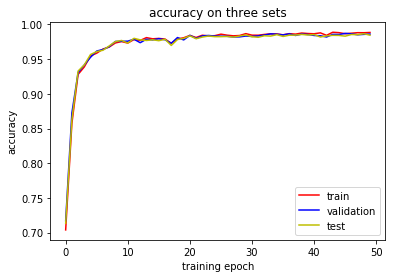

In [9]:
plt.figure(2)
ptr,=plt.plot(range(max_epoch),acc_train_his,'r-')
pva,=plt.plot(range(max_epoch),acc_val_his,'b-')
pte,=plt.plot(range(max_epoch),acc_test_his,'y-')
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.title('accuracy on three sets')
plt.legend((ptr,pva,pte),('train','validation','test'))
plt.show()

In [10]:
saver=tf.train.Saver()
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    saver.restore(sess, "model/RAM/RAM.ckpt")
    _,acc_train=eval(mnist.train,num_train//batch_size)
    _,acc_val=eval(mnist.validation,num_val//batch_size)
    _,acc_test=eval(mnist.test,num_test//batch_size)
    print('Accuracy on training set is %.3f%%' % (acc_train*100.0))
    print('Accuracy on validation set is %.3f%%' % (acc_val*100.0))
    print('Accuracy on testing set is %.3f%%' % (acc_test*100.0))

INFO:tensorflow:Restoring parameters from model/RAM/RAM.ckpt
Accuracy on training set is 98.714%
Accuracy on validation set is 98.357%
Accuracy on testing set is 98.458%


In [11]:
# mean=tf.zeros((100,2),dtype=tf.float32)
# std=tf.constant([1,1],dtype=tf.float32)
# gaussian=tf.distributions.Normal(loc=mean,scale=std)
# rand=tf.random_normal(shape=(100,2),mean=0,stddev=1)
# sampled=mean+rand
# prob=-gaussian.log_prob(sampled)
# prob=tf.reduce_mean(tf.reduce_sum(prob,1))
# with tf.Session() as sess:
#     out=sess.run([prob])
#     print(out)